## 1 Background

In order to manage all useful information and data in these recordings more effectively, I created a class structure called `cage_data`. Each `.pkl` file in the folder `continuous` contains one `cage_data` object, corresponding to one of the 15-minute long recording files. For some practical reasons, we have a 2-second long pause between every two adjacent 15-minute long recording files.

To read those `.pkl` files, first you need to have the codes defining the `cage_data` object in your path. You can find those codes in this [repo](https://github.com/limblab/cage_data). Clone it to your local machine, and simply add it to your path like this:

In [121]:
import fnmatch, os, sys
# Change this path to be wherever your `cage_data` directory is
#sys.path.append('/home/andrew_work/nu/miller_lab_work/cage_data')
sys.path.append('/media/storage/behavior_data/millerlab/cage_data-master')

In [122]:
import cage_data
import numpy as np
from scipy import stats

## 2 Load one file as an example

Data are stored in the variable `my_cage_data`, an instance of the `cage_data` class.

In [123]:
import pickle

data_path = '/media/storage/behavior_data/millerlab/continuous/'
file_name = '20201020_Pop_Cage_005.pkl'
print('The file %s is going to be loaded'%(data_path + file_name))
with open ( data_path + file_name, 'rb' ) as fp:
    my_cage_data = pickle.load(fp)
my_cage_data.pre_processing_summary()

The file /media/storage/behavior_data/millerlab/continuous/20201020_Pop_Cage_005.pkl is going to be loaded
This is a non-sorted file
EMG filtered? -- True
EMG filtered? -- True
Cortical data cleaned? -- True
Data binned? -- True
Spikes smoothed? -- True


## 3 Some basic information about the file just loaded

In [124]:
print('There are %d cortical channels'%(len(my_cage_data.spikes)))
print('There are %d EMG channels'%(len(my_cage_data.EMG_diff)))
print('The raw EMG signals are sampled at %.3f Hz'%(my_cage_data.EMG_fs))
print('There are %d behavior segments in this file'%(len(my_cage_data.behave_tags['tag'])))
print('The length of this file is %.3f seconds'%(my_cage_data.EMG_timeframe[-1]))
print('Spikes and EMGs are binned or downsampled with %.2f seconds time bins'%(my_cage_data.binned['timeframe'][1]-my_cage_data.binned['timeframe'][0]))

There are 72 cortical channels
There are 15 EMG channels
The raw EMG signals are sampled at 2011.061 Hz
There are 177 behavior segments in this file
The length of this file is 900.096 seconds
Spikes and EMGs are binned or downsampled with 0.05 seconds time bins


## 4 How to get raw EMGs?

The raw EMGs are acquired by DSPW wireless system with an Intan RHD2132 frontend. Since the channels on RHD2132 are all single-ended, we do software differential after getting the signals. Therefore, here the raw EMGs are stored in a field called `EMG_diff`.

More specifically, `EMG_diff` is an attribute of the `cage_data` class, and could be accessed by calling:
* raw_EMGs = my_cage_data.EMG_diff

And the sampling frequency of the raw EMGs could be obtained by calling:
* fs_raw_EMG = my_cage_data.EMG_fs

The time frame of the raw EMGs could be obtained by calling:
* raw_EMG_timeframe = my_cage_data.EMG_timeframe

The names of each EMG channel could be got by:
* EMG_names = my_cage_data.EMG_names

In [125]:
raw_EMGs = my_cage_data.EMG_diff
print('There are %d channels, and each channel has %d time samples'%(len(raw_EMGs), len(raw_EMGs[0])))

raw_EMG_timeframe = my_cage_data.EMG_timeframe

fs_raw_EMG = my_cage_data.EMG_fs
print('The raw EMG signals are sampled %.3f Hz'%(fs_raw_EMG))

EMG_names = my_cage_data.EMG_names  # these are abbreviated names for muscles

There are 15 channels, and each channel has 1810148 time samples
The raw EMG signals are sampled 2011.061 Hz


Here `raw_EMGs` is a list

## 5 How to get raw spike timings?

Raw spike timings are stored with the attribute `spikes`, and could be got like this:
* spike_timing = my_cage_data.spikes

In [126]:
spike_timing = my_cage_data.spikes

Here `spike_timing` is a list

## 6 How to get binned / downsampled spike counts and filtered EMG envelops? 

The binned data is stored with another attribute named `binned`. It is a dictionary, and could be accessed like this:
* binned = my_cage_data.binned

There are 4 fields in this dictionary:
* spikes: binned spike counts
* filtered_EMG: EMG envelops been rectified, filtered and downsampled
* FSR_data: the data from force sensitive resistors inside the plastic cage, only meaningful for power grasping
* timeframe: the common time frame for the 3 types of data above

Data in the files we are using now are binned with 50 ms time bins

In [127]:
print(my_cage_data.binned.keys())

# To get the binned spike counts
binned_spike_counts = my_cage_data.binned['spikes']

# To get the rectified, filtered and downsampled EMGs
filtered_EMG = my_cage_data.binned['filtered_EMG']

# To get the time frame of the binned data
timeframe = my_cage_data.binned['timeframe']

# print(np.array(filtered_EMG).shape)
print(my_cage_data.binned['timeframe'])

dict_keys(['timeframe', 'spikes', 'filtered_EMG', 'FSR_data'])
[7.50000e-02 1.25000e-01 1.75000e-01 ... 8.99925e+02 8.99975e+02
 9.00025e+02]


## 7 How to get the information about the monkey's behavior?
The start time and end time and the type of the behaivor of each behavior segment are stored with the attribute `behave_tags`, which is also a dictionary. It has 3 fields, and the names of them are self-explanatory:

* start_time
* end_time
* tag

For example, check the 74th behavior segment in this file:

In [128]:
N = 0
print('During the %dth behavior segment, the monkey was doing \'%s\''%(N, my_cage_data.behave_tags['tag'][N]))
print('The start time of the %dth behavior segment is at the %.3f second'%(N, my_cage_data.behave_tags['start_time'][N]))
print('The end time of the %dth behavior segment is at the %.3f second'%(N, my_cage_data.behave_tags['end_time'][N]))

During the 0th behavior segment, the monkey was doing 'crawling'
The start time of the 0th behavior segment is at the 16.744 second
The end time of the 0th behavior segment is at the 20.511 second


In [129]:
set(my_cage_data.behave_tags['tag'])

{'crawling', 'grooming', 'high picking treats', 'low picking treats', 'pg'}

Note the index of the first behavior segment is "_0_"

In fact, the behavior segments stored in the files I shared last time are generated by the function below. But since we already have them, further introduction is not needed here

In [130]:
behavior_segs = my_cage_data.get_all_data_segment(requires_raw_EMG = True, requires_spike_timing = True)

In [131]:
behavior_segs[0].keys()

dict_keys(['spike', 'EMG', 'timeframe', 'label', 'EMG_names', 'unit_names', 'raw_EMG', 'raw_EMG_timeframe', 'raw_EMG_fs', 'spike_timing'])

# 8 Autocorrelation Analysis for Finding Sequence Length

<IPython.core.display.Javascript object>


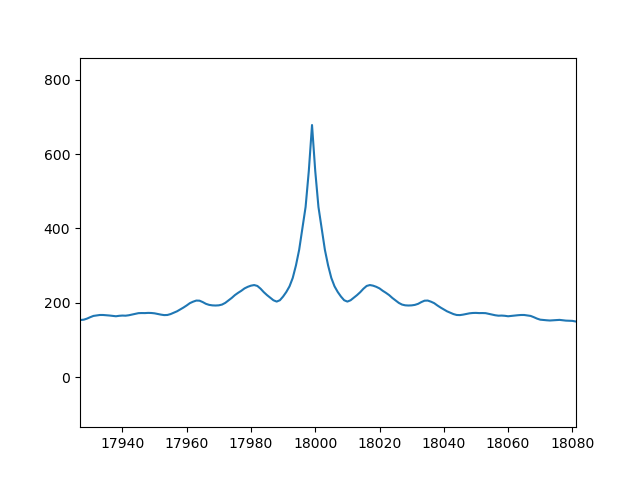

In [132]:
# YOU DON'T NEED TO RUN THIS - See where autocorrelation drops off in order to pick a sequence length 
%matplotlib notebook
muscles = np.array(filtered_EMG)[:10000]

from scipy.stats import pearsonr, zscore
import matplotlib.pyplot as plt

auto_corrs = 0
muscles = muscles - np.mean(muscles, axis=0)

for i, muscle in enumerate(muscles):
    auto_corrs += (np.correlate(muscle, muscle, mode="full")) / len(muscle)
auto_corrs /= 16
plt.plot(auto_corrs)

# 9 Converting to Recurrent VAE Data Format

In [133]:
# Create cage data objects for each of the files of interest - if you have / want more, just add them to the list
dir_path = '/media/storage/behavior_data/millerlab/continuous/'
cage_data_filenames = [dir_path+'20201020_Pop_Cage_005.pkl']
#                        dir_path+'20201020_Pop_Cage_002.pkl',
#                        dir_path+'20201020_Pop_Cage_003.pkl',
#                        dir_path+'20201020_Pop_Cage_004.pkl',
#                        dir_path+'20201020_Pop_Cage_005.pkl',
#                        dir_path+'20201020_Pop_Cage_006.pkl',
#                        dir_path+'20201020_Pop_Cage_007.pkl',]
# cage_data_objs = []
# for fn in cage_data_filenames:
#     with open (fn, 'rb' ) as fp:
#         my_cage_data = pickle.load(fp)
#         cage_data_objs.append(my_cage_data.get_all_data_segment(requires_raw_EMG = True, 
#                                                                 requires_spike_timing = True))

In [119]:
for file in cage_data_filenames:
    with open (file, 'rb' ) as fp:
        temp = pickle.load(fp)
    print(set(temp.behave_tags['tag']))

{'low picking treats', 'pg', 'high picking treats', 'crawling', 'grooming'}


In [141]:
# Set the desired sequence length
SEQ_LEN = 10

# Create behavior class dict for mapping - these are all the currently labeled behaviors they gave us
# bhvs = {'sitting_still': np.array([0]),
#         'crawling': np.array([1]), 
#         'pg': np.array([2]),
#         'grooming': np.array([3]),
#         'no_behavior': np.array([-1])}

bhvs = {'crawling': np.array([0]),
        'high picking treats': np.array([1]),
        'low picking treats': np.array([2]),
        'pg': np.array([3]),
        'sitting still': np.array([4]),
        'grooming': np.array([5]),
        'no_behavior': np.array([-1])}

# Create inverse mapping for debugging
#inv_bhvs = {v: k for k, v in bhvs.items()}
inv_bhvs = {int(v): k for k, v in bhvs.items()}

# Sort all behavior segments by their start timestep - NOT EVERY EMG HAS A BEHAVIOR ASSIGNED TO IT 
behavior_segs = sorted(behavior_segs, key=lambda k: k['timeframe'][0])

# To get the rectified, filtered and downsampled EMGs
filtered_EMG = my_cage_data.binned['filtered_EMG']
filtered_EMG = np.array(filtered_EMG).T
print(f'filtered_EMG shape: {filtered_EMG.shape}')

# To get the time frame of the binned data
timeframe = my_cage_data.binned['timeframe']
print(f'timeframe shape: {timeframe.shape}')
rem = timeframe.shape[0] % SEQ_LEN
if rem != 0:
    time_seqs = np.array(timeframe)[:-rem].reshape(-1, SEQ_LEN)
else:
    time_seqs = np.array(timeframe).reshape(-1, SEQ_LEN)
print(f'time seqs shape: {time_seqs.shape}')

# Create list of tuples (time_stamp, behavior)
emg_lbls = []
for i, time in enumerate(timeframe):
    curr_time_tup = None
    for seg in behavior_segs:
        if time >= seg['timeframe'][0] and time <= seg['timeframe'][-1]:
            curr_emg_tup = np.concatenate((bhvs[seg['label']], filtered_EMG[i]))
            break
        else:
            curr_emg_tup = np.concatenate((bhvs['no_behavior'], filtered_EMG[i]))
    emg_lbls.append(curr_emg_tup)


# Create array where timestamp is first dimension and behavior class is second
emg_lbls = np.array(emg_lbls)
print(f'emg labels shape: {emg_lbls.shape}')

# Chop off last last frames so we can evenly divide
rem = emg_lbls.shape[0] % SEQ_LEN
if rem != 0:
    emg_lbls = emg_lbls[:-rem, :]
emg_lbls = emg_lbls.reshape(-1, SEQ_LEN, 16)
print(f'emg labels shape: {emg_lbls.shape}')

# Find the most represented class in each sequence
out = []
overlap_idx = int(SEQ_LEN * 0.5)
for i, emg_seq in enumerate(emg_lbls):
    # Append indexed sequence with its class
    seq_class = stats.mode(emg_seq[:,0])[0]
    flat_emg = emg_seq[:,1:].reshape(-1)
    out.append(np.concatenate((seq_class, flat_emg)))
    
    # Add 50% time overlap array to output
    if i < len(emg_lbls) - 1:
        overlap = np.concatenate((emg_seq[overlap_idx:, :], emg_lbls[i][:overlap_idx, :]), axis=0)
        overlap_class = stats.mode(overlap[:,0])[0]
        flat_overlap = overlap[:,1:].reshape(-1)
        out.append(np.concatenate((overlap_class, flat_overlap)))

out = np.array(out)
print(f'output shape: {out.shape}')

# Change the path here to be wherever you want to save the data to
np.savetxt('/home/roton2/ruize/timeseries-clustering-vae/data/EMG/EMG3_len10_TRAIN', out, delimiter=',')
np.savetxt('/home/roton2/ruize/timeseries-clustering-vae/data/EMG/EMG3_len10_TEST', out, delimiter=',')

filtered_EMG shape: (18000, 15)
timeframe shape: (18000,)
time seqs shape: (1800, 10)
emg labels shape: (18000, 16)
emg labels shape: (1800, 10, 16)
output shape: (3599, 151)


In [138]:
x = [1,2,3,4,5]
x = np.array(x)
x[:-0]

array([], dtype=int64)

## 10 A function to filter the raw EMGs
A number of useful functions are designed as the methods of the `cage_data` behavior. This one is used to filter the raw EMGs and then to get the EMG envelops
* EMG_filtering(self, f_Hz), `f_Hz` is the corner frequency of the low pass filter to get the envelops

There is no return from this function. This function will update (or create if not existing) the attribute `filtered_EMG`.

Note that here `filtered_EMG` is an attribute of the `cage_data` class, which is different from the field `filtered_EMG` under the attribute `binned`


In [10]:
# Filtering the raw EMGs with a 15 Hz low-pass filter and to get the rectified envelops, all done with this function
my_cage_data.EMG_filtering(15)
EMG_envelops = my_cage_data.filtered_EMG

All EMG channels have been filtered.


As no downsampling or binning is performed here, the obtained EMG envelops are still have the same sampling frequency as the raw EMGs, which is `my_cage_data.EMG_fs` as mentioned above.

## 11 A function to bin the spikes and downsample the EMGs
Although the files shared in Box are all binned with 50 msec bins, you can still use this function to re-bin the data. After doing this, the items in the attribute `binned` will be updated.
* bin_data(self, bin_size, mode = 'center')

`bin_size` is the size of the bin in seconds. `mode` is the way to align the time bins, `center` is OK, and another option is `left`

This function will not return a value either. It only update the attribute `binned`

In [ ]:
new_bin_size = 0.02 # 20 msec
my_cage_data.bin_data(new_bin_size)

## 12 More...

By calling the function `save_to_pickle` like this:
* my_cage_data.save_to_pickle(save_path, save_file_name)

You could save the instance you updated.

If the `my_cage_data` instance is occupying too much memory, just delete it like this
* del(my_cage_data)

You could pull different types of data from it and save them individually before deleting it

In [30]:
filt_EMG_arr = np.array(filtered_EMG)
fig2 = plt.figure(constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=2, nrows=8, figure=fig2)
    
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax1.plot()
f2_ax2 = fig2.add_subplot(spec2[1, 0])
f2_ax3 = fig2.add_subplot(spec2[2, 0])
f2_ax4 = fig2.add_subplot(spec2[3, 0])
f2_ax1 = fig2.add_subplot(spec2[4, 0])
f2_ax2 = fig2.add_subplot(spec2[5, 0])
f2_ax3 = fig2.add_subplot(spec2[6, 0])
f2_ax4 = fig2.add_subplot(spec2[7, 0])

f3_ax1 = fig2.add_subplot(spec2[0, 1])
f3_ax2 = fig2.add_subplot(spec2[1, 1])
f3_ax3 = fig2.add_subplot(spec2[2, 1])
f3_ax4 = fig2.add_subplot(spec2[3, 1])
f3_ax1 = fig2.add_subplot(spec2[4, 1])
f3_ax2 = fig2.add_subplot(spec2[5, 1])
f3_ax3 = fig2.add_subplot(spec2[6, 1])
f3_ax4 = fig2.add_subplot(spec2[7, 1])

16